# Deep Convolutional GAN (DCGAN)

DCGAN 구현 및 관련 항목 설명을 위해 본 Jupyter Notebook을 활용하였습니다.
실험은 MNIST와 MNIST Fashion DB를 통해 진행하였습니다.

- 먼저 구현에 필요한 tensorflow 및 keras library를 import 합니다.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display 

- 다음으로 실험에서 활용할 변수들을 설정해 줍니다.

In [3]:
z_dim = 100         # Generator input noise dimension
lr = 1e-4           # Learning rate
batch_size = 64     # Batch size 
epochs = 30          # Number of epochs
n_of_showcase = 4   # Number of showcase. 실험결과 예제의 수를 정합니다.

mnist_type = "number" # mnist DB의 종류를 정합니다. Choose number or fashion

- Keras를 이용하여 numpy array 형태의 mnist DB를 불러옵니다. MNIS에는 number와 fashion 두 종류의 DB가 있으며, 두 DB는 동일한 size의 image와 동일한 분량의 DB로 구성되어 있습니다. 해당 library는 친절하게 train과 test set을 분리해주며 각각의 set안에 image와 label을 tuple 형태로 반환해 줍니다.

In [4]:
if mnist_type == 'number':
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
elif mnist_type == 'fashion':
    (train_images, train_labels), (tese_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
else:
    print("Please choose 'number' or 'fashion'")
    exit()

In [5]:
print(type(train_images), type(train_labels), type(test_images), type(test_labels))
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


- DB를 변환시켜 줍니다. Image의 경우 generator에서 output layer에 activation 함수로 tanh를 사용하고 있기 때문에, image의 pixel 값을 -1과 1사이 값으로 변환해 줍니다. 또한 CNN 입력의 경우 channel 정보도 포함해야 하기 때문에 tf.newaxis를 통해 맨뒤에 차원을 추가해 줍니다. MNIST는 1 channel 정보이기 때문에 차원만 추가해주면 됩니다. Label의 경우 tensor의 형태로 바꿔줍니다. 본 code에서는 label은 사용하지 않지만 snipet으로 쓸 일이 있을 테니 그냥 변환해 둡니다.

In [6]:
train_images = tf.cast(train_images[..., tf.newaxis] / 255, tf.float32)
train_images = (train_images - 0.5) * 2.0

test_images = tf.cast(test_images[..., tf.newaxis] / 255, tf.float32)
test_images = (test_images - 0.5) * 2.0

train_labels = tf.cast(train_labels, tf.int64)
test_labels = tf.cast(test_labels, tf.int64)

- 변환된 모양은 아래와 같이 나타납니다.

In [7]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

(TensorShape([60000, 28, 28, 1]),
 TensorShape([60000]),
 TensorShape([10000, 28, 28, 1]),
 TensorShape([10000]))

- tf.data를 통해 훈련에 사용할 훈련 DB의 객체를 설정합니다. 아래와 같이 설정된 경우, dataset은 for문 안에서 iterator와 같이 전체 훈련 데이터를 모두 소비할 때까지 batch size 만큼의 training image를 생성하고 우리는 이를 간단하게 훈련에 활용할 수 있습니다.

In [8]:
#dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = tf.data.Dataset.from_tensor_slices(train_images)
dataset = dataset.shuffle(60000).batch(batch_size)

- DCGAN의 generator를 정의합니다. tf.keras.layer를 통해 입력부터 출력까지의 layer를 연결시키고, tf.keras.Model을 통해 입력과 출력을 명시하면 model 구성이 완료됩니다. 정의된 model의 spec은 tf.keras.Model의 summary method를 통해 확인할 수 있습니다.
- Generator의 첫번째 layer는 100차원의 random noise를 입력으로 받으며, 이후 이를 7 X 7, 256 channel feature map으로 변환합니다. Generator의 출력은 training DB와 image size가 동일해야 하기 때문에, 상위 layer로 가면서 stride를 통해 feature map의 size는 2배로 키우고 channel 수는 축소 시킵니다. 최종적으로 generator는 28 X 28 X 1의 결과를 출력하게 됩니다. 

In [9]:
generator_input = keras.Input(shape=(z_dim,), name='z_in')
x = layers.Dense(7*7*256, use_bias=False)(generator_input)
x = layers.BatchNormalization()(x)
x = layers.Reshape((7, 7, 256))(x)

x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

generator_output = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh', name="gen_img")(x)

generator = keras.Model(generator_input, generator_output, name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_in (InputLayer)            [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 128)         0 

- DCGAN의 discriminator를 정의합니다. Generator와 동일하게 tf.keras.layer를 통해 입력부터 출력까지의 layer를 연결시키고, tf.keras.Model을 통해 입력과 출력을 명시하면 model 구성이 완료됩니다. 마찬가지로 정의된 model의 spec은 tf.keras.Model의 summary method를 통해 확인할 수 있습니다.
- Discriminator는 28 X 28 X 1의 image 입력을 받아 이것이 진짜 training data인지 generator에서 만들어진 fake image인지를 구분하는 역할을 수행합니다. 이에 통상적인 CNN 기반의 분류기와 비슷한 구성을 취하지만, pooling 은 사용하지 않습니다. 최종 discriminator의 output은 fake image와 real image를을 0과 1로 구분짓는 sigmoid 함수를 출력하게 됩니다.

In [10]:
discriminator_input = keras.Input(shape=(28, 28, 1), name='img_in')
x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
discriminator_output = layers.Dense(1, activation='sigmoid', name='disc_out')(x)

discriminator = keras.Model(discriminator_input, discriminator_output, name='discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)       

- Generator와 discriminator의 구성이 완료되어 훈련에 필요한 것들을 정의할 차례입니다. 먼저 훈련에 사용할 optimizer와 loss 함수를 선택합니다. 여기서는 Adam optimizer와 discriminator sigmoid 출력에 맞는 BinaryCrossentropy를 선택하였습니다.

In [11]:
opt = optimizers.Adam(lr)
xent = losses.BinaryCrossentropy()

- 선택된 loss 함수를 통해 generator와 discriminator를 훈련하는데 활용할 loss를 정의합니다.
- 먼저 discriminator는 일반적인 classification과 정의합니다. 앞서 정한바와 같이 real image에는 1의 label을 fake image에는 0의 label을 부여합니다. 그리고 이 둘을 더해주면 discriminator를 훈련하는데 활용될 loss 함수의 정의가 완료됩니다.
- 다음으로 generator의 차례입니다. Generator는 자신이 생성한 image가 discriminator를 잘 속일 수 있어야 하므로, 1의 label을 만들어 낼 수 있도록 하는 label을 부여하고 이를 통해 loss 함수를 정의합니다.

In [12]:
def d_loss_calc(real_output, fake_output):
    real_loss = xent(tf.ones_like(real_output), real_output)
    fake_loss = xent(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def g_loss_calc(fake_output):
    return xent(tf.ones_like(fake_output), fake_output)

- 추가적으로 훈련과정을 관찰할 수 있는, batch 단위 loss 평균값 그리고 discriminator의 분류 정확도 볼 수 있는 함수를 선택합니다. 보통 GAN은 generator가 discriminator를 잘 속이도록 훈련되어야 하기 때문에, 훈련과정에서 분류 정확도가 너무 높아지는 것을 경계해야합니다. 훈련이 진행되는 동안에 문제가 생기는지를 관찰하기 위해 아래와 같이 준비해 둡니다.

In [13]:
train_loss = metrics.Mean(name='tr_loss', dtype=tf.float32)
train_accuracy = metrics.BinaryAccuracy(name='tr_acc', dtype=tf.float32)

- 다음으로 하나의 batch 내에서 이루어지는 훈련 함수를 정의합니다. TF 2.0에서는 더이상 session을 사용하지 않고 tf.function decorator를 사용합니다. tf.function은 하위 정의된 함수의 기능을 graph로 만들어주며, 이를 통해 빠른 계산을 가능하게 만들어 줍니다. 아래의 함수는 모델 훈련에 있어 핵심적인 부분이며, 가장 많은 계산량을 담당하고 있으므로, 이를 tf.function을 통해 정의하는 것이 좋습니다. 다만 tensorflow guide상에서 tf.function가 높은 호환성을 가지고 있다고 말하고 있으나, graph로 만들 필요가 없는 여러 tensorflow 외부 기능들이 포함될 경우, 많은 오류를 발생시킬 수 있으니, 계산상 필요한 것들만을 기술하는 것이 좋습니다.

내부의 기능들을 살펴보면,

1. Gererator의 입력을 정의하고,
2. 다음 gradient 계산을 위한 tf.GradientTape의 context안에 입력에서 출력까지 모델 내부에서 gradient가 계산되어야 할 부분을 기술합니다.
3. 훈련시 Forward propagation call에 해당하는 부분에 training=True argument 설정은 중요합니다. 각각의 입력에 따라 다른 출력들을 정의합니다.
4. 각 출력에 대해 loss를 정의합니다.
5. GradienTape을 통해 gradient를 계산합니다.
6. 계산된 gradient를 opmizer를 통해 반영합니다.
7. 훈련 과정 관찰을 위해 loss 평균 및 discriminator의 분류 정확도를 계산합니다.

In [14]:
@tf.function
def train_step(images):
    z_noises = tf.random.normal(shape=(batch_size, z_dim))               # 1.
    
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:      # 2.
        fake_images = generator(z_noises, training=True)                # 3.
        
        d_out_fake = discriminator(fake_images, training=True)          # 3.
        d_out_real = discriminator(images, training=True)               # 3.
        
        d_loss = d_loss_calc(d_out_real, d_out_fake)                     # 4.
        g_loss = g_loss_calc(d_out_fake)                                 # 4.
    
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables) # 5.
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)     # 5.
    
    opt.apply_gradients(zip(d_grads, discriminator.trainable_variables)) # 6.
    opt.apply_gradients(zip(g_grads, generator.trainable_variables))     # 6.
    
    train_loss(d_loss)                                                   # 7.
    train_accuracy(tf.concat([tf.zeros_like(d_out_fake), tf.ones_like(d_out_real)], axis=0),
                   tf.concat([d_out_fake, d_out_real], axis=0))

- 훈련 진행시 중간중간 생성되는 모델을 저장하기 위한 checkpoint를 정의합니다.

In [15]:
checkpoint_dir = './train_ckpts'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt,                                 
                                 generator=generator,
                                 discriminator=discriminator)

- 훈련이 진행되는 동안 loss와 accuracy로는 판단하기 어려운 generator의 훈련 정도를 관찰하기 위해 epoch 마다 고정된 random 입력으로부터 생성되는 image를 관찰 및 저장하기 위한 함수를 정의합니다.

In [16]:
def gen_and_save_img(epoch, test_input):    
    img = generator(test_input, training=False)
    img = tf.reshape(img, [-1, 28, 28])
    
    plt.figure(figsize=(4,4))    
    for i in range(img.shape[0]):
        plt.subplot(n_of_showcase, n_of_showcase, i+1)
        plt.imshow(img[i]/2.0 + 0.5, cmap=plt.cm.binary_r)
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

마지막으로 전체 훈련을 관장할 함수를 정의합니다.

1. 먼저 generator의 훈련경과를 관찰하는데 사용될 random data를 정의합니다.
2. 하나의 epoch 내의 동작을 정의합니다.
3. 하나의 batch 및 특정 크기의 step별 동작을 정의합니다.
4. 훈련이 끝난 뒤 동작을 정의합니다.

In [17]:
# 1. 먼저 generator의 훈련경과를 관찰하는데 사용될 random data를 정의합니다.
gen_ckt_in = tf.random.normal([n_of_showcase ** 2, z_dim])                         

def train(dataset, epochs):
    tf.print("Start training DCGAN")
    global_start = time.time()    

    # 2. 하나의 epoch 내의 동작을 정의합니다.
    for epoch in range(epochs):                                              
        epoch_start = time.time()
        step = 0
        
        # 3. 하나의 batch 및 특정 크기의 step별 동작을 정의합니다.
        for images in dataset:                                               
            step += 1
            train_step(images)
            if tf.equal(step % 200, 0):      # Step size는 batch size X 200이며 각 step마다 결과 display.
                tf.summary.scalar('loss', train_loss.result(), step=opt.iterations)
                tf.summary.scalar('acc', train_accuracy.result()*100, step=opt.iterations)
                template = "Epoch: {:2d}, Step: {:2d}, Tr_Loss: {:.4f}, Tr_Acc: {:.4f}"
                tf.print(template.format(epoch + 1, int(step / 200), train_loss.result(), train_accuracy.result()*100))

        display.clear_output(wait=True)
        gen_and_save_img(epoch + 1, gen_ckt_in)  # 각 epoch 경과 후, generator image display
        
        tf.print ('Time for epoch {:2d} is {:3.0f} sec'.format(epoch + 1, time.time()-epoch_start))  # 각 epoch 결과 display

        if (epoch + 1) % 5 == 0: # 5 epoch마다 model checkpoint를 저장합니다.
            checkpoint.save(file_prefix = checkpoint_prefix)        
 
    # 4. 훈련이 끝난 뒤 동작을 정의합니다.
    # 마지막 결과 display
    display.clear_output(wait=True)
    gen_and_save_img(epochs, gen_ckt_in)

    template = "Training Time: {:4.0f} sec, Final Tr_Loss: {:.4f}, Final Tr_Accuracy: {:.4f} for {:2d} epochs"
    tf.print(template.format(time.time()-global_start, train_loss.result(), train_accuracy.result()*100, epochs))

- TensorBoard를 통한 훈련과정 기록에 필요한 것을 정의하고, 훈련을 실행합니다.

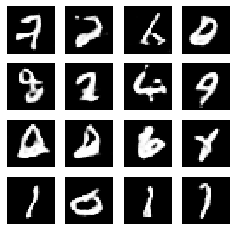

Training Time:  576 sec, Final Tr_Loss: 1.2478, Final Tr_Accuracy: 64.6989 for 30 epochs


In [18]:
tr_summary_writer = tf.summary.create_file_writer('./summaries/train')
with tr_summary_writer.as_default():
    train(dataset, epochs)

- 결과 확인을 위해 가장 마지막에 저장된 model을 불러옵니다.

In [19]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

- Latent space, 즉 generator의 입력 공간에서 두개의 random point를 정하여 이 두개의 점을 잇는 line 위에서의 interpolation을 통해 각각의 point 별로 generator에서 생성되는 image를 관찰합니다. 본래 두개의 image를 선형적으로 interpolation하게 되면 단순히 두개의 image가 overlap된 상태에서 하나의 image가 옅어지고 다른 하나의 image가 진해지는 식인데 반해 latent space에서의 선형적인 이동이 image space에서는 비선형적인 manifold 상에서의 이동으로 보여지는 것을 관찰하기 위한 code 입니다. 

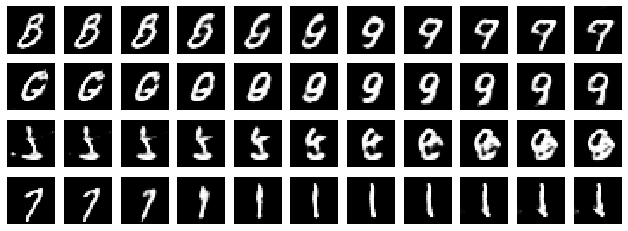

In [20]:
def gen_interpolated_img(test_input):
    img = generator(test_input, training=False)
    img = tf.reshape(img, [-1, 28, 28])
    
    plt.figure(figsize=(11,n_of_showcase))    
    for i in range(img.shape[0]):
        plt.subplot(n_of_showcase, 11, i+1)
        plt.imshow(img[i]/2.0 + 0.5, cmap=plt.cm.binary_r)        
        plt.axis('off')    
    plt.show()

# 4개의 pair로 이루어진 random data를 뽑습니다.
pair_gen_ckt_in = tf.random.normal([n_of_showcase, 2, z_dim]) 
# 0에서 1까지 0.1 단위의 interpolation을 수행합니다.
interpolated_img = [[pair_gen_ckt_in[j][0]*i/10 + pair_gen_ckt_in[j][1]*(1-i/10) for i in range(11)] for j in range(n_of_showcase)]
interpolated_img = tf.reshape(interpolated_img, [-1, 100])
# 위에서 얻어진 random data를 generator에 입력하여 image를 확인합니다.
gen_interpolated_img(interpolated_img)

- Latent space에서의 semantic 정보의 산술연산을 관찰하기 위한 code 입니다. 이를테면 (남자, 웃음) - (남자, 무표정) = (0, 웃음 - 무표정) + (여자, 무표정) = (여자, 웃음 - 무표정 + 무표정 = 웃음)에 해당하는 image를 얻을 수 있는지 확인하기 위한 실험적인 code 입니다.

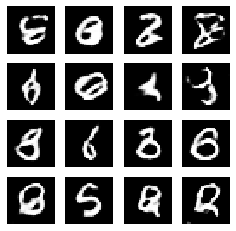

In [21]:
def gen_arithmatic_img(test_input):
    img = generator(test_input, training=False)
    img = tf.reshape(img, [-1, 28, 28])
    
    plt.figure(figsize=(4, n_of_showcase))    
    for i in range(img.shape[0]):
        plt.subplot(n_of_showcase, 4, i+1)
        plt.imshow(img[i]/2.0 + 0.5, cmap=plt.cm.binary_r)        
        plt.axis('off')    
    plt.show()

# 산술연산을 위해 4개의 triplet random data (A, B, C)를 뽑습니다.
triplet_gen_ckt_in = tf.random.normal([n_of_showcase, 3, z_dim])
# A - B + C = D를 수행합니다.
arithmatic_img = [triplet_gen_ckt_in[i][0] - triplet_gen_ckt_in[i][1] + triplet_gen_ckt_in[i][2] for i in range(n_of_showcase)]
arithmatic_img = tf.convert_to_tensor(arithmatic_img)
arithmatic_img = tf.expand_dims(arithmatic_img, 1)
arithmatic_img = tf.concat([triplet_gen_ckt_in, arithmatic_img], axis=1)
arithmatic_img = tf.reshape(arithmatic_img, [-1, 100])
# A, B, C, D에 해당하는 randomdata를 입력하여 결과를 관찰합니다.
gen_arithmatic_img(arithmatic_img)